Number of components needed for:
70% energy: 2
80% energy: 3
90% energy: 5
95% energy: 7


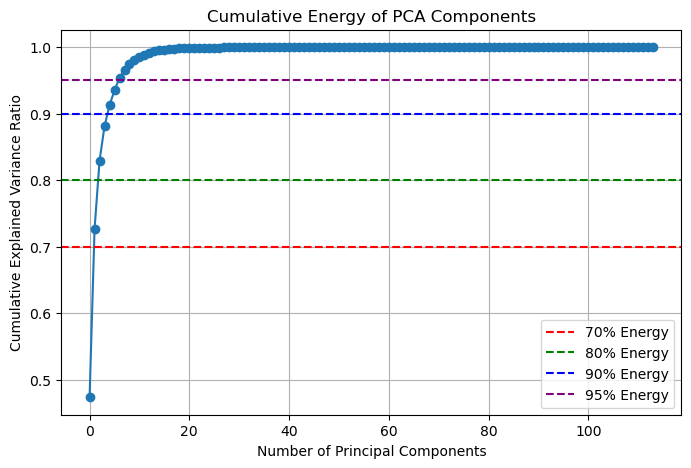

In [86]:
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

file_paths = [
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/jumping_1.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/jumping_2.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/jumping_3.npy",
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/jumping_4.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/jumping_5.npy",
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/running_1.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/running_2.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/running_3.npy",
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/running_4.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/running_5.npy",
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/walking_1.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/walking_2.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/walking_3.npy",
    "/Users/nicknugraha/AMATH482/HW2/hw2data/train/walking_4.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/train/walking_5.npy"
]

X_train = np.hstack([np.load(fp) for fp in file_paths])
pca = PCA()
X_pca = pca.fit_transform(X_train.T) 

cumulative_energy = np.cumsum(pca.explained_variance_ratio_)

energy_levels = [0.70, 0.80, 0.90, 0.95]
num_components = [np.argmax(cumulative_energy >= level) + 1 for level in energy_levels]

plt.figure(figsize=(8, 5))
plt.plot(cumulative_energy, marker='o', linestyle='-')
plt.axhline(y=0.70, color='r', linestyle='--', label="70% Energy")
plt.axhline(y=0.80, color='g', linestyle='--', label="80% Energy")
plt.axhline(y=0.90, color='b', linestyle='--', label="90% Energy")
plt.axhline(y=0.95, color='purple', linestyle='--', label="95% Energy")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Energy of PCA Components")
plt.legend()
plt.grid(True)
# plt.show()

print("Number of components needed for:")
for i, level in enumerate(energy_levels):
    print(f"{int(level * 100)}% energy: {num_components[i]}")


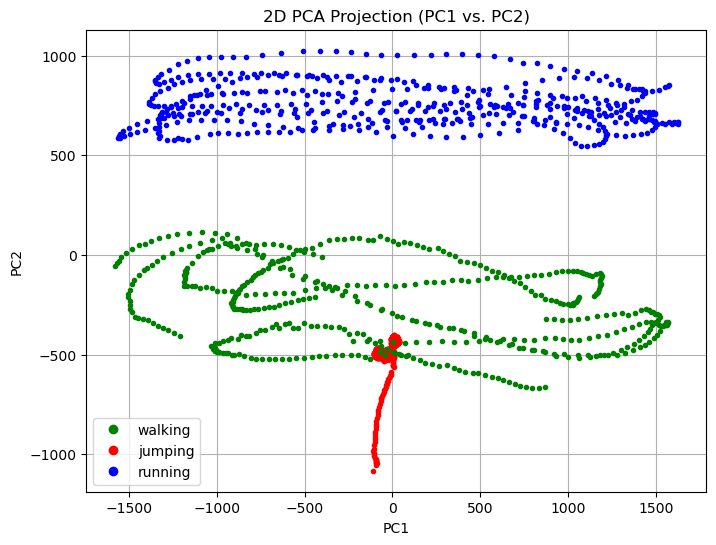

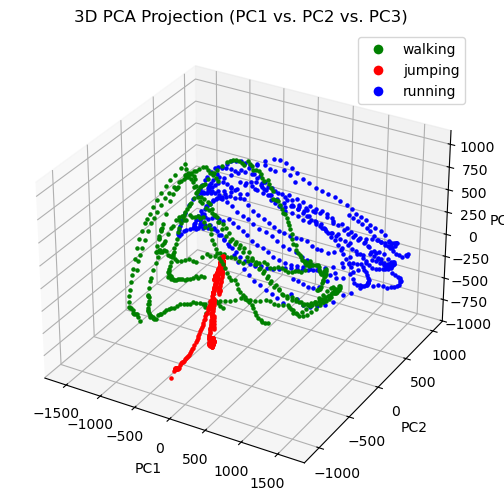

In [ ]:
X_pca_2D = X_pca[:, :2]  
X_pca_3D = X_pca[:, :3]  

movement_label_map = {"walking": 0, "jumping": 1, "running": 2}
movement_labels = ( ["jumping"] * 5 + ["running"] * 5 + ["walking"] * 5)

expanded_labels = sum([[label] * 100 for label in movement_labels], [])

colors = {"walking": "green", "jumping": "red", "running": "blue"}
expanded_color_list = [colors[label] for label in expanded_labels]

plt.figure(figsize=(8, 6))
for i in range(len(X_pca_2D)):
    plt.plot(X_pca_2D[i, 0], X_pca_2D[i, 1], 'o', color=expanded_color_list[i], markersize=3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection (PC1 vs. PC2)")
plt.grid(True)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, 
              markerfacecolor=color, markersize=8) for label, color in colors.items()])
# plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X_pca_3D)):
    ax.scatter(X_pca_3D[i, 0], X_pca_3D[i, 1], X_pca_3D[i, 2], color=expanded_color_list[i], s=5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection (PC1 vs. PC2 vs. PC3)")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, 
              markerfacecolor=color, markersize=8) for label, color in colors.items()])
# plt.show()

In [ ]:
ground_truth_labels = np.array([movement_label_map[label] for label in expanded_labels])

# Compute centroids in k-mode PCA space for each movement type
centroids_kD = {}

for movement, movement_id in movement_label_map.items():
    indices = np.where(ground_truth_labels == movement_id)  # Find indices of movement type
    centroids_kD[movement] = np.mean(X_pca[indices], axis=0)  # Compute mean in k-dimensional PCA space

# Display computed centroids for k modes
print("Centroids in k-mode PCA space:")
for movement, centroid in centroids_kD.items():
    print(f"{movement} centroid: {centroid[:10]}... (truncated)")



Centroids in k-mode PCA space:
walking centroid: [ -36.88211143 -253.35282541  175.91202104  -30.2908448   -41.62513671
   30.88972875  137.99009566   26.0733214   -25.63493388   34.82653522]... (truncated)
jumping centroid: [ -23.88986635 -499.36826149  -72.5000755    28.58077286   -1.89232891
  -20.0651196  -126.86355676  -20.48932207   20.02812291  -26.35626011]... (truncated)
running centroid: [  60.77197779  752.7210869  -103.41194553    1.71007194   43.51746561
  -10.82460915  -11.1265389    -5.58399933    5.60681097   -8.47027511]... (truncated)


In [ ]:
k_vals = [2, 3, 5, 10, 20, X_pca.shape[1]]
train_accuracy_results = {}

for k in k_vals:
    X_pca_kD = X_pca[:, :k]
    trained_labels = np.zeros(len(X_pca_kD), dtype=int)

    for i in range(len(X_pca_kD)):
        distances = {}

        for movement in centroids_kD:
            sample = X_pca_kD[i]
            centroid = centroids_kD[movement][:k]
            distance = np.linalg.norm(sample - centroid)
            distances[movement] = distance

        closest_movement = min(distances, key=distances.get)
        trained_labels[i] = movement_label_map[closest_movement]
    
    accuracy = accuracy_score(ground_truth_labels, trained_labels)
    train_accuracy_results[k] = accuracy

print(train_accuracy_results)


{2: 0.8813333333333333, 3: 0.756, 5: 0.7506666666666667, 10: 0.888, 20: 0.9106666666666666, 114: 0.9106666666666666}


In [101]:
test_file_paths = ["/Users/nicknugraha/AMATH482/HW2/hw2data/test/jumping_1t.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/test/running_1t.npy", "/Users/nicknugraha/AMATH482/HW2/hw2data/test/walking_1t.npy"]
X_test = np.hstack([np.load(fp) for fp in test_file_paths])

test_labels = np.array(
    [movement_label_map["jumping"]] * 100 +
    [movement_label_map["running"]] * 100 +
    [movement_label_map["walking"]] * 100
)

X_test_pca = pca.transform(X_test.T)

test_accuracy_results = {}

for k in k_vals:
    X_test_pca_kD = X_test_pca[:, :k]

    predicted_test_labels = np.zeros(len(X_test_pca_kD), dtype=int)

    for i in range(len(X_test_pca_kD)):
        distances = {}

        for movement in centroids_kD:
            sample = X_test_pca_kD[i]
            centroid = centroids_kD[movement][:k]
            distance = np.linalg.norm(sample - centroid)
            distances[movement] = distance

        closest_movement = min(distances, key=distances.get)
        predicted_test_labels[i] = movement_label_map[closest_movement]
        
    accuracy = accuracy_score(test_labels, predicted_test_labels)
    test_accuracy_results[k] = accuracy


print(test_accuracy_results)
    

{2: 0.9833333333333333, 3: 0.9233333333333333, 5: 0.9166666666666666, 10: 0.9433333333333334, 20: 0.9533333333333334, 114: 0.9533333333333334}
